# Fine-tuning BERT on long texts

## Truncation Method

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install transformers==2.10.0

In [ ]:
import sys
sys.path.append("./drive/MyDrive/ML-Project/RoBERT")

%matplotlib inline
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import transformers
from transformers import RobertaTokenizer, BertTokenizer, RobertaModel, BertModel, AdamW# get_linear_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup
import time

from utils import *
from Custom_Dataset_Class import NewsGroupDataset
from Bert_Classification import Bert_Classification_Model_20NG
from RoBERT import RoBERT_Model

from BERT_Hierarchical import BERT_Hierarchical_Model
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### All segments approach

In [ ]:
TRAIN_BATCH_SIZE=1
EPOCH=5
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=NewsGroupDataset(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)

Loading BERT tokenizer...



Data Cleaning


In [ ]:
device=torch.device("cuda")
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=Bert_Classification_Model_20NG().to(device)
optimizer=AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\nEpoch {epoch+1}/{EPOCH}\n")
    batches_losses_tmp=train_loop_fun1(train_data_loader, model, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"Average loss : {epoch_loss:.2f} - {(time.time()-t0)//60}min ({time.time()-t0:.2f}sec\n")
    t1=time.time()
    output, target, val_losses_tmp=eval_loop_fun1(valid_data_loader, model, device)
    print(f"Average Validation loss: {np.mean(val_losses_tmp):.2f} - {time.time()-t1:.2f}sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print("Model saved in Drive")
    torch.save(model, f"./drive/MyDrive/ML-Project/RoBERT/20_newsgroup/model1/model_epoch{epoch+1}.pt")    



Epoch 1/5

0/2201 (0.00%) - 0.56sec - loss = 2.6921
250/2201 (11.36%) - 64.13sec - loss = 2.1498
500/2201 (22.72%) - 64.93sec - loss = 1.2292
750/2201 (34.08%) - 67.64sec - loss = 1.1605
1000/2201 (45.43%) - 70.52sec - loss = 0.6918
1250/2201 (56.79%) - 79.17sec - loss = 1.3125
1500/2201 (68.15%) - 65.62sec - loss = 0.7826
1750/2201 (79.51%) - 65.18sec - loss = 0.8078
2000/2201 (90.87%) - 62.45sec - loss = 0.8239
Average loss : 1.33 - 9.0min (596.18sec

Average Validation loss: 1.06 - 101.85sec

{'accuracy': 0.6814404432132964, 'nb exemple': 3249, 'true_prediction': 2214, 'false_prediction': 1035}
Model saved in Drive

Epoch 2/5

0/2201 (0.00%) - 0.39sec - loss = 1.0643
250/2201 (11.36%) - 68.80sec - loss = 0.9474
500/2201 (22.72%) - 61.55sec - loss = 0.7648
750/2201 (34.08%) - 68.02sec - loss = 0.6155
1000/2201 (45.43%) - 73.19sec - loss = 0.7267
1250/2201 (56.79%) - 72.12sec - loss = 0.4632
1500/2201 (68.15%) - 66.39sec - loss = 0.7685
1750/2201 (79.51%) - 69.92sec - loss = 0.3949


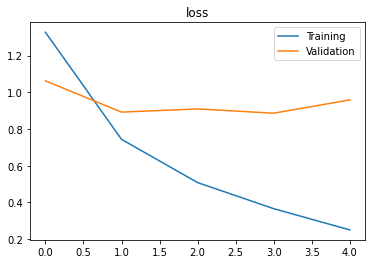

In [ ]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses], [np.mean(x) for x in val_losses]]).T, columns=['Training', 'Validation']).plot(title="loss")

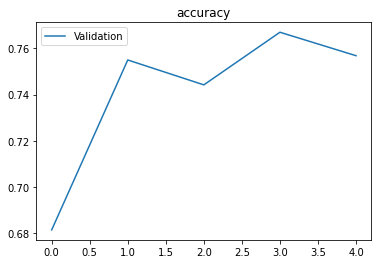

In [ ]:
pd.DataFrame(np.array(val_acc).T, columns=['Validation']).plot(title="accuracy")

### Head Segment Approach

In [ ]:
TRAIN_BATCH_SIZE=8
EPOCH=1
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

approach='head'

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=NewsGroupDataset(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN,
    approach=approach)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device=torch.device("cuda")
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=Bert_Classification_Model_20NG().to(device)
optimizer=AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\nEpoch {epoch+1}/{EPOCH}\n")
    batches_losses_tmp=train_loop_fun1(train_data_loader, model, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"Average loss : {epoch_loss:.2f} - {(time.time()-t0)//60}min {time.time()-t0:.2f}sec\n")
    t1=time.time()
    output, target, val_losses_tmp=eval_loop_fun1(valid_data_loader, model, device)
    print(f"Average Validation loss: {np.mean(val_losses_tmp):.2f} - {time.time()-t1:.2f}sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"\Truncation {approach} only model has been saved in the drive")
    torch.save(model, f"./drive/MyDrive/ML-Project/RoBERT/20_newsgroup/model_truncation/{approach}_only/model_{approach}_only_epoch{epoch+1}.pt")

Loading BERT tokenizer...



Data Cleaning




Epoch 1/1

0/276 (0.00%) - 0.62sec - loss = 2.9852
250/276 (90.58%) - 174.99sec - loss = 0.7936
Average loss : 1.63 - 3.0min 189.44sec

Average Validation loss: 0.89 - 19.40sec

{'accuracy': 0.7436363636363637, 'nb exemple': 550, 'true_prediction': 409, 'false_prediction': 141}
\Truncation head only model has been saved in the drive


### Tail Segment Approach

In [ ]:
TRAIN_BATCH_SIZE=8
EPOCH=1
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000
approach='tail'

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=NewsGroupDataset(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN,
    approach=approach)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device=torch.device("cuda")
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=Bert_Classification_Model_20NG().to(device)
optimizer=AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\nEpoch {epoch+1}/{EPOCH}\n")
    batches_losses_tmp=train_loop_fun1(train_data_loader, model, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"Average loss : {epoch_loss:.2f} - {(time.time()-t0)//60}min {time.time()-t0:.2f}sec\n")
    t1=time.time()
    output, target, val_losses_tmp=eval_loop_fun1(valid_data_loader, model, device)
    print(f"Average Validation loss: {np.mean(val_losses_tmp):.2f} - {time.time()-t1:.2f}sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"\Truncation {approach} only model has been saved in the drive")
    torch.save(model, f"./drive/MyDrive/ML-Project/RoBERT/20_newsgroup/model_truncation/{approach}_only/model_{approach}_only_epoch{epoch+1}.pt")

Loading BERT tokenizer...
Data Cleaning

Epoch 1/1

0/276 (0.00%) - 1.64sec - loss = 3.2029
250/276 (90.58%) - 169.77sec - loss = 1.2494
Average loss : 1.83 - 3.0min 188.44sec

Average Validation loss: 1.12 - 21.08sec

{'accuracy': 0.6690909090909091, 'nb exemple': 550, 'true_prediction': 368, 'false_prediction': 182}
\Truncation tail only model has been saved in the drive
